<a href="https://colab.research.google.com/github/PavelStelmakhV/hw306-pyspark/blob/main/Hw6.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=e4a63412f4fe4a0981952c0f1613c2c7a31d017523de961039012ffde4eb7cef
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [2]:
from google.colab import drive
from google.colab import files


drive.mount('/content/drive')
path = '/content/drive/My Drive/'
file_name = 'bestsellers with categories.csv'

Mounted at /content/drive


# Задание 1

In [3]:
import pandas as pd
import pyspark
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, stddev, round as _round
from pyspark.sql.types import *


Создать спарк сессию

In [4]:
spark = SparkSession.builder.getOrCreate()

Прочитать датасет в датафрейм.

In [5]:
csv_file = path + file_name
data_schema = [
               StructField('name', StringType(), True),
               StructField('author', StringType(), True),
               StructField('user_rating', FloatType(), True),
               StructField('reviews', IntegerType(), True),
               StructField('price', FloatType(), True),
               StructField('year', IntegerType(), True),
               StructField('genre', StringType(), True),
            ]
final_struc = StructType(fields = data_schema)
df = spark.read.csv(csv_file, header=True, schema=final_struc)

In [6]:
df.show(3)

+--------------------+------------------+-----------+-------+-----+----+-----------+
|                name|            author|user_rating|reviews|price|year|      genre|
+--------------------+------------------+-----------+-------+-----+----+-----------+
|10-Day Green Smoo...|          JJ Smith|        4.7|  17350|  8.0|2016|Non Fiction|
|   11/22/63: A Novel|      Stephen King|        4.6|   2052| 22.0|2011|    Fiction|
|12 Rules for Life...|Jordan B. Peterson|        4.7|  18979| 15.0|2018|Non Fiction|
+--------------------+------------------+-----------+-------+-----+----+-----------+
only showing top 3 rows



Используя только RDD вычислить среднюю цену всех книг, у которых рейтинг выше 4.7

In [7]:
df.filter(df.user_rating >= 4.7).agg({"price": "avg"}).show()

+-----------------+
|       avg(price)|
+-----------------+
|10.69832402234637|
+-----------------+



Построить гистограмму распределения рецензий (столбец Reviews).

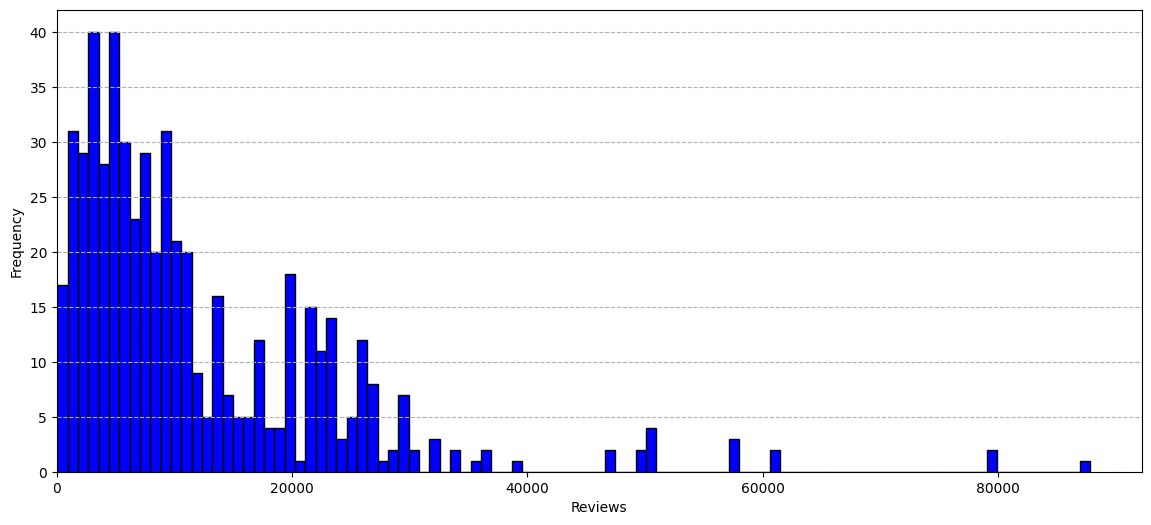

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize = (14,6))
plt.hist(df.toPandas()['reviews'], color = 'blue', edgecolor = 'black', bins = 100)
plt.xlabel('Reviews')
plt.ylabel('Frequency')
plt.xlim(0, None)
plt.grid(linestyle='--', axis='y')
plt.show()

Построить матрицу корреляции для столбцов "User Rating", "Reviews" и "Price".

In [9]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

assembler = VectorAssembler(
    inputCols=["user_rating", "reviews", "price"],
    outputCol="features")
df_features = assembler.transform(df)
r1 = Correlation.corr(df_features, "features").head()
print("Pearson correlation matrix (user_rating, reviews, price):\n" + str(r1[0]))

Pearson correlation matrix (user_rating, reviews, price):
DenseMatrix([[ 1.        , -0.00172901, -0.13308631],
             [-0.00172901,  1.        , -0.10918188],
             [-0.13308631, -0.10918188,  1.        ]])


Используя библиотеку seaborn построить парные графики (pairplots) столбцов "User Rating", "Reviews" и "Price".

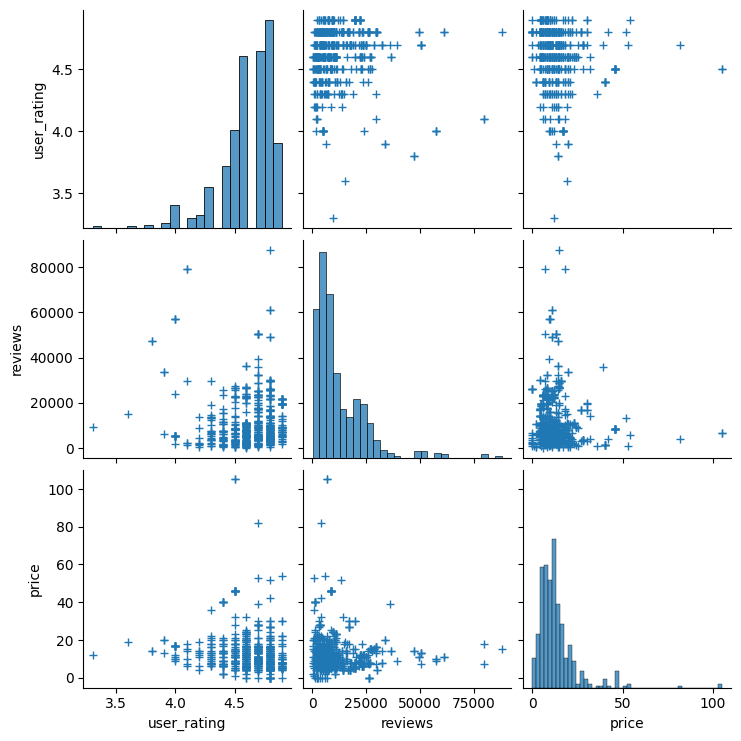

In [10]:
import seaborn as sns

sns.pairplot(df.select(["user_rating", "reviews", "price"]).toPandas(), 
             diag_kind="hist", 
             plot_kws=dict(marker="+", linewidth=1),
             )
plt.show()

# Задание 2

In [11]:
df.createOrReplaceTempView("Books")

Найдите автора с самым высоким рейтингом

In [12]:
spark.sql(
    """
    Select 
      author as `Author`, max(user_rating) as `Max rating`
    From Books 
    Group By author
    Order by `Max rating` desc
    Limit 1
    """
).show()
    

+-----------+----------+
|     Author|Max rating|
+-----------+----------+
|Sarah Young|       4.9|
+-----------+----------+



Найдите трех авторов с самым низким рейтингом.

In [13]:
spark.sql(
    """
    Select 
      author as `Author`, min(user_rating) as `Min rating`
    From Books 
    Group By author
    Order by `Min rating`
    Limit 3
    """
).show()

+------------+----------+
|      Author|Min rating|
+------------+----------+
|J.K. Rowling|       3.3|
|  Harper Lee|       3.6|
|   E L James|       3.8|
+------------+----------+



Определите какой автор получил наибольшее количество рецензий.

In [14]:
spark.sql(
    """
    Select 
      author as `Author`, sum(reviews) as `Total reviews`
    From Books 
    Group By author
    Order by `Total reviews` desc
    Limit 1
    """
).show()

+---------------+-------------+
|         Author|Total reviews|
+---------------+-------------+
|Suzanne Collins|       278329|
+---------------+-------------+



Определите какой автор написал наибольшее количество книг за весь доступный в данных период.

In [15]:
spark.sql(
    """
    Select 
      author as `Author`, COUNT(name) as `Count books`
    From Books 
    Group By author
    Order by `Count books` desc
    Limit 1
    """
).show()

+-----------+-----------+
|     Author|Count books|
+-----------+-----------+
|Jeff Kinney|         12|
+-----------+-----------+



Определите какая книга жанра "Fiction" имеет самый маленький рейтинг.

In [16]:
spark.sql(
    """
    Select 
      name as `Book`, min(user_rating) as `Min rating`
    From Books
    WHERE genre="Fiction" 
    Group By `Book`
    Order by `Min rating`
    Limit 1
    """
).head()[0]

'The Casual Vacancy'

Определите какая книга жанра "Non Fiction" имеет самый высокий рейтинг.

In [17]:
spark.sql(
    """
    Select 
      name as `Book`, max(user_rating) as `Max rating`
    From Books
    WHERE genre="Non Fiction" 
    Group By `Book`
    Order by `Max rating` desc
    Limit 1
    """
).head()[0]

'Obama: An Intimate Portrait'

# Задание 3

Постройте гистограмму среднего количества рецензий по годам. В виде отдельной гистограммы визуализируйте количество книг жанра "Fiction" и "Non Fiction" за весь доступный период.

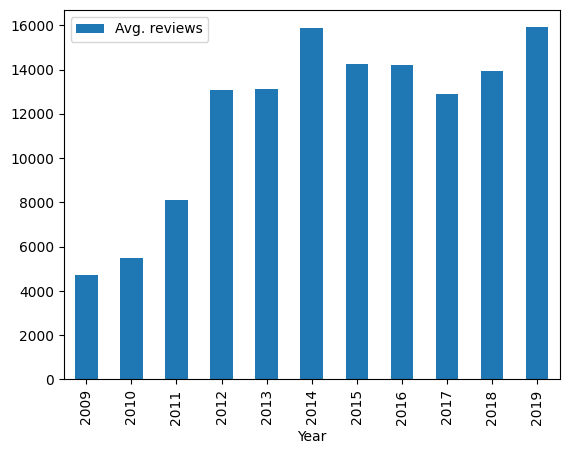

In [22]:
spark.sql(
    """
    Select 
      year as `Year`, avg(reviews) as `Avg. reviews`
    From Books 
    Group By `Year`
    Order by `Year`
    """
).toPandas().plot(x='Year', y='Avg. reviews', kind='bar')
plt.show()

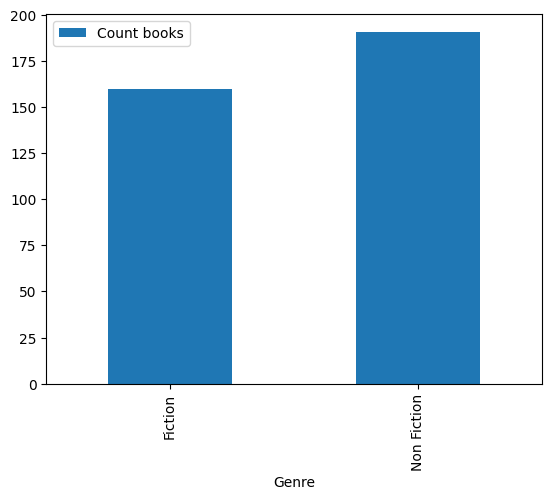

In [31]:
spark.sql(
    """
    Select DISTINCT
     genre as `Genre`, COUNT(DISTINCT name) as `Count books`
    From Books 
    Group By `Genre`
    """
).toPandas().plot(x='Genre', y='Count books', kind='bar')
plt.show()

In [18]:
df.filter('genre == "Non Fiction"').orderBy('user_rating', ascending=False).show()

+--------------------+------------------+-----------+-------+-----+----+-----------+
|                name|            author|user_rating|reviews|price|year|      genre|
+--------------------+------------------+-----------+-------+-----+----+-----------+
|Hamilton: The Rev...|Lin-Manuel Miranda|        4.9|   5867| 54.0|2016|Non Fiction|
|Humans of New Yor...|   Brandon Stanton|        4.9|   2812| 17.0|2015|Non Fiction|
|Jesus Calling: En...|       Sarah Young|        4.9|  19576|  8.0|2011|Non Fiction|
|Jesus Calling: En...|       Sarah Young|        4.9|  19576|  8.0|2012|Non Fiction|
|Jesus Calling: En...|       Sarah Young|        4.9|  19576|  8.0|2013|Non Fiction|
|Jesus Calling: En...|       Sarah Young|        4.9|  19576|  8.0|2014|Non Fiction|
|Jesus Calling: En...|       Sarah Young|        4.9|  19576|  8.0|2015|Non Fiction|
|Jesus Calling: En...|       Sarah Young|        4.9|  19576|  8.0|2016|Non Fiction|
|Obama: An Intimat...|        Pete Souza|        4.9|   3192| 22.